## Импорт библиотек и данных, построение модели

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsp
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import *

import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_excel('Данные для прогноза.xlsx').dropna()

model = VECM(endog=data[['vkontakte', 'youtube']], deterministic="co", k_ar_diff=2, coint_rank=1).fit()
print(model.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation vkontakte
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4.715e+11   1.38e+11      3.428      0.001    2.02e+11    7.41e+11
L1.vkontakte    -0.7580      0.350     -2.163      0.031      -1.445      -0.071
L1.youtube       0.5837      0.209      2.796      0.005       0.175       0.993
L2.vkontakte    -0.9509      0.354     -2.684      0.007      -1.645      -0.256
L2.youtube       0.7068      0.222      3.191      0.001       0.273       1.141
Det. terms outside the coint. relation & lagged endog. parameters for equation youtube
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         7.749e+11    2.5e+11      3.101      0.002    2.85e+11    1.26e+12
L1.vkontakte  

## Проведение тестов

### Автокорреляция

**Тест на автокоррелированность остатков модели множителя Лагранжа (LM):**

$H_0:$ В наборе данных нет автокорреляции

$H_1:$ В наборе данных есть автокорреляция

In [163]:
from statsmodels.stats.diagnostic import acorr_lm

vk_autocorr = acorr_lm(model.resid[:, 0])[1]
ytb_autocorr = acorr_lm(model.resid[:, 1])[1]

print('p-value теста автокоррелированности остатков для ВКонтакте = ', vk_autocorr)
print('p-value теста автокоррелированности остатков для YouTube = ', ytb_autocorr)

p-value теста автокоррелированности остатков для ВКонтакте =  0.6919571419567503
p-value теста автокоррелированности остатков для YouTube =  0.796687205266803


Таким образом, остатки в обоих моделях нельзя назвать автокоррелированными.

**Тест на случайность остатков модели Льюнга-Бокса и Бокса-Пирса:**

$H_0:$ данные распределены независимо (то есть представляют собой белый шум)

$H_1:$ данные не являются независимо распределенными

In [182]:
from statsmodels.stats.diagnostic import acorr_ljungbox

vk_rand = acorr_ljungbox(x=model.resid[:, 0], lags=5, boxpierce=True)
ytb_rand = acorr_ljungbox(x=model.resid[:, 1], lags=5, boxpierce=True)

In [180]:
print('p-value для ВКонтакте')
vk_rand[['lb_pvalue', 'bp_pvalue']]

p-value для ВКонтакте


,lb_pvalue,bp_pvalue
1,0.590071,0.607489
2,0.844487,0.858185
3,0.868480,0.889535
4,0.840870,0.877780
5,0.505473,0.626278


In [183]:
print('p-value для YouTube')
ytb_rand[['lb_pvalue', 'bp_pvalue']]

p-value для YouTube


,lb_pvalue,bp_pvalue
1,0.580528,0.598266
2,0.825430,0.840950
3,0.774629,0.810250
4,0.838271,0.873507
5,0.680005,0.766864


Как можно заметить, для всех лагов нулевая гипотеза неотвергается в соответствии с тестами Льюнга-Бокса-Пирса. Следовательно остатки модели распределены независимо и, таким образом, автокорреляции не наблюдается.

### Нормальность

**Тест на нормальность распределения остатков Харке-Беры:**

$H_0:$ Данные порождены нормальным распределением

$H_1:$ Данные порождены не-нормальным распределением

In [171]:
from statsmodels.stats.stattools import jarque_bera

vk_norm = jarque_bera(model.resid[:, 0])[1]
ytb_norm = jarque_bera(model.resid[:, 1])[1]

print('p-value теста нормальности распределения остатков для ВКонтакте = ', vk_norm)
print('p-value теста нормальности распределения остатков для YouTube = ', ytb_norm)

p-value теста нормальности распределения остатков для ВКонтакте =  0.8011341780531394
p-value теста нормальности распределения остатков для YouTube =  0.8639589940015613


Таким образом, остатки в обоих моделях распределены нормально

## Построение прогноза и графиков

In [98]:
fc = model.predict(steps=6, alpha=0.1)
vk_hat = fc[0][:, 0]
vk_hat = np.insert(vk_hat, 0, data['vkontakte'].values[-1])
ytb_hat = fc[0][:, 1]
ytb_hat = np.insert(ytb_hat, 0, data['youtube'].values[-1])

vk_lower = fc[1][:, 0]
ytb_lower = fc[1][:, 1]

vk_upper = fc[2][:, 0]
ytb_upper = fc[2][:, 1]

vk_fit = model.fittedvalues[:, 0]
ytb_fit = model.fittedvalues[:, 1]

In [110]:
for_index = pd.read_excel('Dannye_unikalnye_posetiteli.xlsx')
index = pd.to_datetime(for_index['date'], format='%Y-%m-%d')
index = index[for_index.shape[0] - data.shape[0]:]

fit_index = index[-vk_fit.shape[0]:]
forecast_index = pd.date_range(start='2023-10-01', end='2024-06-01', freq='ME')[1:]

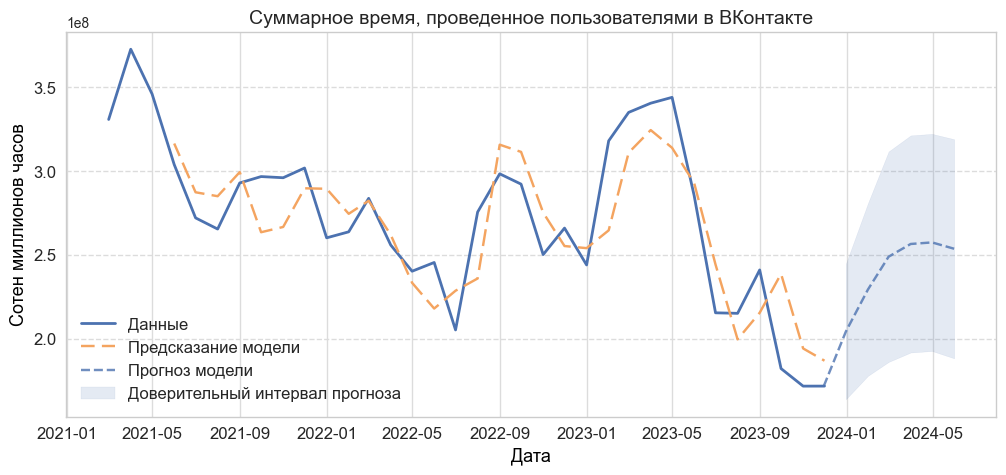

In [147]:
plt.figure(figsize=[12, 5])
plt.style.use("seaborn-v0_8-whitegrid")

plt.plot(index, data['vkontakte'].values / 3600, color='C0',
         label='Данные', linewidth=2)
plt.plot(fit_index, vk_fit / 3600, color='sandybrown', linestyle=(1.4, (7, 3)), 
         linewidth=1.75, label='Предсказание модели')
plt.plot(forecast_index, vk_hat / 3600, color='C0', linestyle='--', 
         linewidth=1.75, label='Прогноз модели', alpha=0.8)
plt.fill_between(forecast_index[1:], vk_lower / 3600, vk_upper / 3600,
                 color='C0', alpha=.15, label="Доверительный интервал прогноза")

plt.xlabel('Дата', fontsize = 13, color='black')
plt.ylabel('Сотен миллионов часов', fontsize = 13, color='black')
plt.grid(axis ='x', which='major', linestyle='-', color='gainsboro')
plt.grid(axis ='y', which='major', linestyle='--', color='gainsboro')
plt.tick_params(axis='x', labelsize=12, color='black')
plt.tick_params(axis='y', labelsize=12)
plt.title('Суммарное время, проведенное пользователями в ВКонтакте', fontsize=14)
plt.legend(fontsize=12)

plt.savefig('vk.svg', dpi=300)

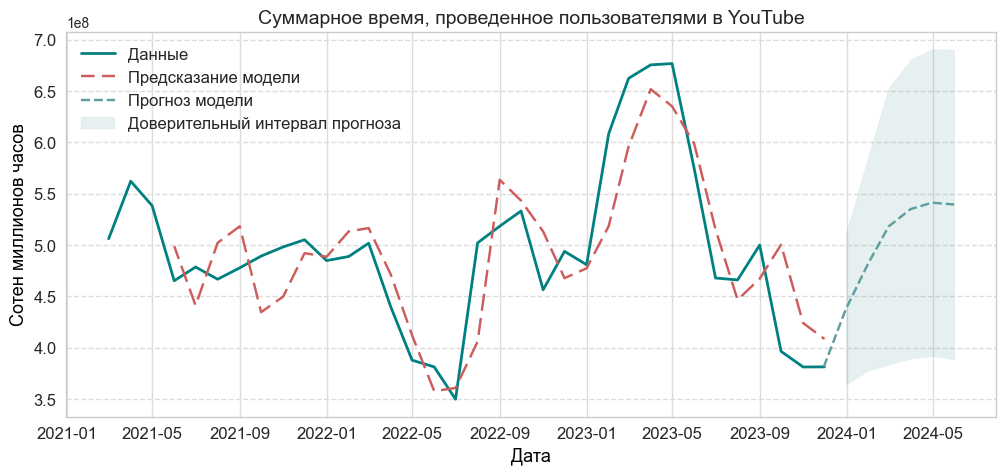

In [148]:
plt.figure(figsize=[12, 5])
plt.style.use("seaborn-v0_8-whitegrid")

plt.plot(index, data['youtube'].values / 3600, color='teal',
         label='Данные', linewidth=2)
plt.plot(fit_index, ytb_fit / 3600, color='indianred', linestyle=(1.4, (7, 3)), 
         linewidth=1.75, label='Предсказание модели')
plt.plot(forecast_index, ytb_hat / 3600, color='cadetblue', linestyle='--', 
         linewidth=1.75, label='Прогноз модели')
plt.fill_between(forecast_index[1:], ytb_lower / 3600, ytb_upper / 3600,
                 color='cadetblue', alpha=.15, label="Доверительный интервал прогноза")

plt.xlabel('Дата', fontsize = 13, color='black')
plt.ylabel('Сотен миллионов часов', fontsize = 13, color='black')
plt.grid(axis ='x', which='major', linestyle='-', color='gainsboro')
plt.grid(axis ='y', which='major', linestyle='--', color='gainsboro')
plt.tick_params(axis='x', labelsize=12, color='black')
plt.tick_params(axis='y', labelsize=12)
plt.title('Суммарное время, проведенное пользователями в YouTube', fontsize=14)
plt.legend(fontsize=12)

plt.savefig('ytb.svg', dpi=300)